In [110]:
loader = DataLoader(selected_datasets_per_qtype['exist'], batch_size=2, shuffle=False, num_workers=0, collate_fn=collate_samples_from_pixels)

In [111]:
b = next(iter(loader))

with torch.no_grad():
    model.eval()
    model.coord_tensor = None
    mid_res, _ = mid_getter(b['image'], b['question'])

In [147]:
b['question'][0]

tensor([ 1,  2, 47, 21, 70, 31, 48, 17, 18, 26, 20, 17,  4, 41, 24, 12,  0])

In [119]:
%matplotlib inline

In [116]:
f_activations = torch.stack([mid_res[f'identity_fc{i}'] for i in range(1, 3)], dim=1)

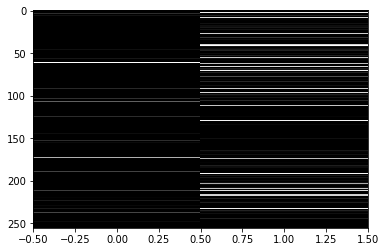

In [120]:
norm_activations = f_activations[0].t() * ((1 / f_activations[0].max(dim=1).values))
plt.imshow(norm_activations.detach().numpy(), aspect='auto', cmap='Greys_r')

In [144]:
g_activations = torch.stack([mid_res[f'identity_gc{i}'].view(-1, 64 * 64 * 256) for i in range(0, 4)], dim=1)

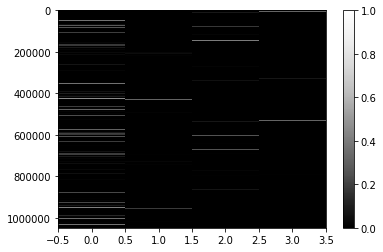

In [145]:
norm_activations_g = g_activations[0].t() * ((1 / g_activations[0].max(dim=1).values))
plt.imshow(norm_activations_g.detach().numpy(), aspect='auto', cmap='Greys_r')
plt.colorbar()

In [146]:
(g_activations[0] == 0).sum(dim=1)

tensor([ 782359,  943729,  982908, 1036209])

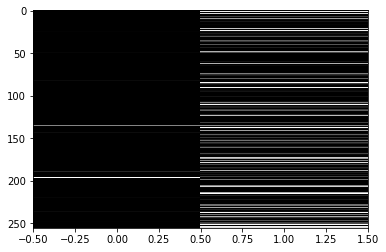

In [121]:
norm_activations2 = f_activations[1].t() * ((1 / f_activations[1].max(dim=1).values))
plt.imshow(norm_activations2.detach().numpy(), aspect='auto', cmap='Greys_r')

In [46]:
X_embedded = TSNE(n_components=2).fit_transform(torch.cat([all_res[qtype]['mha_gc1'] for qtype in qtypes]))

In [36]:
X_embedded

array([[ 153.93373 ,  129.25932 ],
       [ 207.70412 ,  -33.28526 ],
       [ -17.270176,  128.3473  ],
       [ -69.30714 ,  -34.757526],
       [  68.95953 ,   10.983522],
       [  69.73261 , -134.65114 ]], dtype=float32)

In [56]:
%matplotlib notebook

In [58]:
from matplotlib.cm import get_cmap

tab20 = get_cmap('tab20').colors

<IPython.core.display.Javascript object>


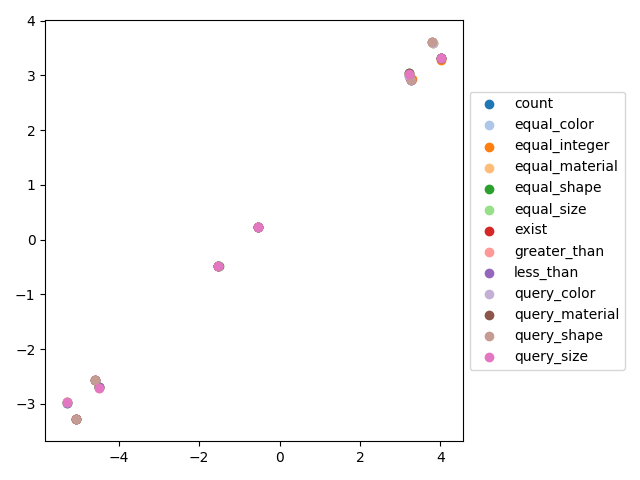

In [65]:
for i, qtype in enumerate(qtypes):
    plt.scatter(
        X_embedded[i * 6:(i + 1) * 6, 0], X_embedded[i * 6:(i + 1) * 6, 1],
        c=[tab20[i]],
        label=qtype,
    )

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json
import pickle

import torch

import numpy as np

from matplotlib import colors
import matplotlib as mpl
import matplotlib.pyplot as plt

from attrdict import AttrDict

from model import RN
from model_vanilla import RN as RNVanilla
from viz_utils import init_selected_datasets, load_model, compute_mid_results, get_all_metrics, mha_keys, identity_keys, plot_masks_per_qtype, plot_masks_histograms, _get_mask_metrics


device = torch.device('cuda:0') if torch.cuda.is_available() else 'cpu'
print(torch.cuda.device_count())
device

1


device(type='cuda', index=0)

In [3]:
selected_ds_per_qtype, dictionaries = init_selected_datasets(
    '/mnt/nas2/GrimaRepo/datasets/CLEVR_v1.0',
    # '/Users/sebamenabar/Documents/datasets/CLEVR/CLEVR_v1.0/',
    '/home/fcorencoret/RelationNetworks-CLEVR/questions/CLEVR_built_dictionaries.pkl',
    # 'viz/CLEVR_built_dictionaries.pkl',
    'viz/selected_idxs_per_qtype.json',
)

with open('config.json', 'r') as f:
    hyp = json.load(f)['hyperparams']['original-fp']
    
qtypes = list(selected_ds_per_qtype.keys())

args = AttrDict()
args.qdict_size = len(dictionaries[0])
args.adict_size = len(dictionaries[1])

==> using cached questions: questions/CLEVR_val_questions.pkl


In [4]:
hyp

{'state_description': False,
 'g_layers': [256, 256, 256, 256],
 'question_injection_position': 0,
 'f_fc1': 256,
 'f_fc2': 256,
 'dropout': 0.5,
 'lstm_hidden': 256,
 'lstm_word_emb': 32,
 'rl_in_size': 52}

In [6]:
# hyp['lstm_hidden'] = 128
model = load_model(
    RN(args, hyp),
    # '/mnt/nas2/GrimaRepo/jahurtado/codes/dynamic-rn/Norm_learn_reg_sb_0.1/best_weights.pth',
    '/home/fcorencoret/RelationNetworks-CLEVR/Norm_L1_0.1_sb_0.5/best_weights.pth',
    [device],
)

Supposing original DeepMind model


RuntimeError: Error(s) in loading state_dict for DataParallel:
	Missing key(s) in state_dict: "module.rl.mha_fc1.norm.weight", "module.rl.mha_fc1.norm.bias", "module.rl.mha_fc2.norm.weight", "module.rl.mha_fc2.norm.bias", "module.rl.mha_fc3.norm.weight", "module.rl.mha_fc3.norm.bias", "module.rl.mha_layers.0.norm.weight", "module.rl.mha_layers.0.norm.bias", "module.rl.mha_layers.1.norm.weight", "module.rl.mha_layers.1.norm.bias", "module.rl.mha_layers.2.norm.weight", "module.rl.mha_layers.2.norm.bias", "module.rl.mha_layers.3.norm.weight", "module.rl.mha_layers.3.norm.bias". 

In [ ]:
model_name = 'Norm SB 0.5'
model_folder = 'Norm_sb_0.5'
if not os.path.exists(f'images/{model_folder}'):
    os.makedirs(f'images/{model_folder}')

In [ ]:
res = compute_mid_results(
    model,
    selected_ds_per_qtype,
    bsz=128,
    device=device,
    samples_per_qtype=256,
    with_identity=True,
    # with_attention=False,
)

In [ ]:
metrics = get_all_metrics(
    res,
    # mha_names=[],
)

In [ ]:
fig, axes = plot_masks_per_qtype(res, adict=dictionaries[1])
fig.suptitle(f'{model_name} - Mean Mask per Question')
fig.show()
fig.savefig(f'images/{model_folder}/mean_mask_per_question.jpg', dpi=200)

In [ ]:
fig, axes = plot_masks_histograms(metrics['agg_metrics'])
fig.suptitle(f'{model_name} - Agg Masks Distribution')
axes[-1].set_xlabel('Mask value')
fig.show()
fig.savefig(f'images/{model_folder}/agg_masks_distribution.jpg', dpi=200)

In [ ]:
ssz = metrics['agg_metrics'][identity_keys[0]]['sparsity'].size(0)

sparsity_histograms = {
    identity_name: _get_mask_metrics(metrics['agg_metrics'][identity_name]['sparsity'].view(ssz, -1))
    for identity_name in identity_keys
}

In [ ]:
fig, axes = plot_masks_histograms(sparsity_histograms, keys=identity_keys)
fig.suptitle(f'{model_name} - Agg Activation Sparsity')
fig.show()
fig.savefig(f'images/{model_folder}/agg_activation_sparsity.jpg', dpi=200)